# Find brick kilns in Delhi NCR

In [2]:
import os

from arcgis.gis import GIS
from arcgis.geocoding import geocode

gis = GIS('https://deldev.maps.arcgis.com', 'demos_deldev', os.environ.get('DEMOSPWD'))

# Inputs

In [3]:
extent = geocode('National Capital Territory of Delhi, NCT, IND', out_sr=3857)[0]['extent']
extent

{'xmin': 8555348.145426257,
 'ymin': 3302118.722598504,
 'xmax': 8610117.334896546,
 'ymax': 3364539.3863827363}

<Item title:"World Imagery" type:Map Image Layer owner:esri>
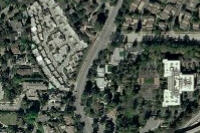

In [4]:
imagery = gis.content.get('10df2279f9684e4a9f6a7f08febac2a9') 
imagery

In [5]:
from arcgis.mapping import MapImageLayer
lyr = MapImageLayer.fromitem(imagery)

# Deploy trained model

### Load model

In [5]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np

from util import load_model, norm, denorm, export_img, get_tile_images, get_img, \
        get_cropped_tiles, predict_, detect_objects, suppress_close_objects, overlap, predict_classf
from model import ConvnetBuilder, SSD_MultiHead, resnet34, k

torch.backends.cudnn.benchmark=True

f_model = resnet34
pretrained = 'models/H.h5'

In [9]:
head_reg = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg)
model = models.model
model = load_model(model, pretrained)
model.eval()

path = r'inferencing_kilns/'

In [10]:
!mkdir $path

In [11]:
import os
import math
import pandas as pd

from arcgis.raster.functions import apply
from arcgis.features import SpatialDataFrame
from arcgis.mapping import MapImageLayer
from arcgis.geometry import Envelope, project
from IPython.display import display

ext = Envelope(extent)
city_ext = project([ext], 3857, 3857)[0]

In [12]:
#df = SpatialDataFrame.from_layer(zoning_lyr.layers[0])
#residential_areas = list(df[df.Zoning=='Residential']['SHAPE'].extent)

areas = Envelope({"xmin": 8555348.145426257, "ymin": 3302118.722598504, "xmax": 8610117.334896546,
                  "ymax": 3364539.3863827363, "spatialReference": 3857})

In [13]:
sz = 224
pixx, pixy = 720, 720
N = 8
w = h = N*pixx - pixx/2

nX = math.ceil((city_ext['xmax'] - city_ext['xmin'])/w)
nY = math.ceil((city_ext['ymax'] - city_ext['ymin'])/h)

objects    = []
inferenced = []
done_imgs  = {}

borders = [ (pixx/2, pixx/2, pixx/2, pixx/2) ] #,   # xmin, ymin, xmax, ymax - map space
#           (22.5, 22.5, 67.5, 67.5),   # bottom left corner
#           (22.5, 67.5, 67.5, 22.5),   # top left corner
#           (67.5, 22.5, 22.5, 67.5),   # bottom right corner
#           (67.5, 67.5, 22.5, 22.5) ]  # top right corner

crops   = [ (sz/2, sz/2, sz/2, sz/2) ] #,  # left, top, right, bottom -> xmin, ymax, xmax, ymin
#             ( 56, 168, 168,  56),  # bottom left corner
#             ( 56,  56, 168, 168),  # top left corner
#             (168, 168,  56,  56),  # bottom right corner
#             (168,  56,  56, 168) ] # top right corner

### Detect brick kilns

In [16]:
for i in range(nX):
    for j in range(nY):
        filename = f'obj_{i}_{j}.jpg'

        xmin = city_ext['xmin'] + (j)*w
        ymin = city_ext['ymax'] - (i+1)*h
        xmax = xmin + N*pixx
        ymax = ymin + N*pixy

        ext = {'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax, 'spatialReference':3857}

        print(filename, 'Detecting...')

        imgpath = path + filename
        print(ext)
        print(imgpath)
        if not os.path.isfile(imgpath):
            print(filename, 'Downloading...')
            imgpath = lyr.export_map(ext, image_sr={'wkid': 4326}, 
                             bbox_sr=3857, size='1792,1792', f='image', 
                             image_format='jpg',
                             save_folder=path,
                  save_file=filename)
        else:
            print('already downloaded.')

        if filename not in inferenced:                        
            img = np.array(Image.open(imgpath))

            #_nrows = int(img.shape[0] / 224)
            #_ncols = int(img.shape[1] / 224)
            tiles = get_tile_images(img)
            #img = img.reshape(64,224,224,3)
            #img_normed = norm(img)


            kilns = detect_objects(model, tiles, ext, cycle=0, side=pixx)
            print(filename, 'Found ' + str(len(kilns)) + ' objects (pass #0)')
            objects.extend(kilns)

            for iii, crop in enumerate(crops):
                paddedtiles = get_cropped_tiles(img, crop)
                kilns = detect_objects(model, paddedtiles, ext, crop=borders[iii], cycle=iii+1, side=pixx)
                print(filename, 'Found ' + str(len(kilns)) + f' objects (pass #{iii+1})')
                objects.extend(kilns)

            inferenced.append(filename)

obj_0_0.jpg Detecting...
{'xmin': 8555348.145426257, 'ymin': 3359139.3863827363, 'xmax': 8561108.145426257, 'ymax': 3364899.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_0_0.jpg
already downloaded.
obj_0_1.jpg Detecting...
{'xmin': 8560748.145426257, 'ymin': 3359139.3863827363, 'xmax': 8566508.145426257, 'ymax': 3364899.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_0_1.jpg
already downloaded.
obj_0_2.jpg Detecting...
{'xmin': 8566148.145426257, 'ymin': 3359139.3863827363, 'xmax': 8571908.145426257, 'ymax': 3364899.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_0_2.jpg
already downloaded.
obj_0_3.jpg Detecting...
{'xmin': 8571548.145426257, 'ymin': 3359139.3863827363, 'xmax': 8577308.145426257, 'ymax': 3364899.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_0_3.jpg
already downloaded.
obj_0_4.jpg Detecting...
{'xmin': 8576948.145426257, 'ymin': 3359139.3863827363, 'xmax': 8582708.145426257, 'ymax': 3364899.3863827363, 'spatialReferenc

obj_2_6.jpg Found 5 objects (pass #0)
obj_2_6.jpg Found 4 objects (pass #1)
obj_2_7.jpg Detecting...
{'xmin': 8593148.145426257, 'ymin': 3348339.3863827363, 'xmax': 8598908.145426257, 'ymax': 3354099.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_2_7.jpg
obj_2_7.jpg Downloading...
obj_2_7.jpg Found 4 objects (pass #0)
obj_2_7.jpg Found 1 objects (pass #1)
obj_2_8.jpg Detecting...
{'xmin': 8598548.145426257, 'ymin': 3348339.3863827363, 'xmax': 8604308.145426257, 'ymax': 3354099.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_2_8.jpg
obj_2_8.jpg Downloading...
obj_2_8.jpg Found 8 objects (pass #0)
obj_2_8.jpg Found 1 objects (pass #1)
obj_2_9.jpg Detecting...
{'xmin': 8603948.145426257, 'ymin': 3348339.3863827363, 'xmax': 8609708.145426257, 'ymax': 3354099.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_2_9.jpg
obj_2_9.jpg Downloading...
obj_2_9.jpg Found 38 objects (pass #0)
obj_2_9.jpg Found 32 objects (pass #1)
obj_2_10.jpg Detecting...
{'xmin': 86

obj_4_10.jpg Found 11 objects (pass #0)
obj_4_10.jpg Found 10 objects (pass #1)
obj_4_11.jpg Detecting...
{'xmin': 8614748.145426257, 'ymin': 3337539.3863827363, 'xmax': 8620508.145426257, 'ymax': 3343299.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_4_11.jpg
obj_4_11.jpg Downloading...
obj_4_11.jpg Found 29 objects (pass #0)
obj_4_11.jpg Found 20 objects (pass #1)
obj_5_0.jpg Detecting...
{'xmin': 8555348.145426257, 'ymin': 3332139.3863827363, 'xmax': 8561108.145426257, 'ymax': 3337899.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_5_0.jpg
obj_5_0.jpg Downloading...
obj_5_0.jpg Found 1 objects (pass #0)
obj_5_0.jpg Found 0 objects (pass #1)
obj_5_1.jpg Detecting...
{'xmin': 8560748.145426257, 'ymin': 3332139.3863827363, 'xmax': 8566508.145426257, 'ymax': 3337899.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_5_1.jpg
obj_5_1.jpg Downloading...
obj_5_1.jpg Found 0 objects (pass #0)
obj_5_1.jpg Found 0 objects (pass #1)
obj_5_2.jpg Detecting...
{'x

obj_7_2.jpg Found 6 objects (pass #0)
obj_7_2.jpg Found 0 objects (pass #1)
obj_7_3.jpg Detecting...
{'xmin': 8571548.145426257, 'ymin': 3321339.3863827363, 'xmax': 8577308.145426257, 'ymax': 3327099.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_7_3.jpg
obj_7_3.jpg Downloading...
obj_7_3.jpg Found 5 objects (pass #0)
obj_7_3.jpg Found 6 objects (pass #1)
obj_7_4.jpg Detecting...
{'xmin': 8576948.145426257, 'ymin': 3321339.3863827363, 'xmax': 8582708.145426257, 'ymax': 3327099.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_7_4.jpg
obj_7_4.jpg Downloading...
obj_7_4.jpg Found 4 objects (pass #0)
obj_7_4.jpg Found 3 objects (pass #1)
obj_7_5.jpg Detecting...
{'xmin': 8582348.145426257, 'ymin': 3321339.3863827363, 'xmax': 8588108.145426257, 'ymax': 3327099.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_7_5.jpg
obj_7_5.jpg Downloading...
obj_7_5.jpg Found 3 objects (pass #0)
obj_7_5.jpg Found 2 objects (pass #1)
obj_7_6.jpg Detecting...
{'xmin': 85877

obj_9_6.jpg Found 3 objects (pass #0)
obj_9_6.jpg Found 4 objects (pass #1)
obj_9_7.jpg Detecting...
{'xmin': 8593148.145426257, 'ymin': 3310539.3863827363, 'xmax': 8598908.145426257, 'ymax': 3316299.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_9_7.jpg
obj_9_7.jpg Downloading...
obj_9_7.jpg Found 3 objects (pass #0)
obj_9_7.jpg Found 2 objects (pass #1)
obj_9_8.jpg Detecting...
{'xmin': 8598548.145426257, 'ymin': 3310539.3863827363, 'xmax': 8604308.145426257, 'ymax': 3316299.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_9_8.jpg
obj_9_8.jpg Downloading...
obj_9_8.jpg Found 3 objects (pass #0)
obj_9_8.jpg Found 4 objects (pass #1)
obj_9_9.jpg Detecting...
{'xmin': 8603948.145426257, 'ymin': 3310539.3863827363, 'xmax': 8609708.145426257, 'ymax': 3316299.3863827363, 'spatialReference': 3857}
inferencing_kilns/obj_9_9.jpg
obj_9_9.jpg Downloading...
obj_9_9.jpg Found 4 objects (pass #0)
obj_9_9.jpg Found 3 objects (pass #1)
obj_9_10.jpg Detecting...
{'xmin': 8609

# Post processing

### Create feature layers

In [17]:
import pickle 
pickle.dump(objects, open(path + 'kilns.pkl', 'wb'))

In [ ]:
import pickle
path = r'brick_kilns/try3/inferencing_kilns/'
objects = pickle.load(open(path + 'kilns.pkl', 'rb'))

In [18]:
len(objects)

1243

In [19]:
for i, obj in enumerate(objects):
    obj['SHAPE'] = {'x': obj['x'], 'y': obj['y']}

sdf = SpatialDataFrame.from_dict(objects)
sdf = sdf.reset_index()
sdf.sr = {'wkid': 3857}

In [20]:
selected, suppressed = suppress_close_objects(sdf, 30)

In [21]:
selected.to_featureclass(r'inferencing', 'selected_kilns.shp')

'inferencing/selected_kilns.shp'

In [22]:
selected.to_featureclass(r'inferencing', 'suppressed_kilns.shp')

'inferencing/suppressed_kilns.shp'

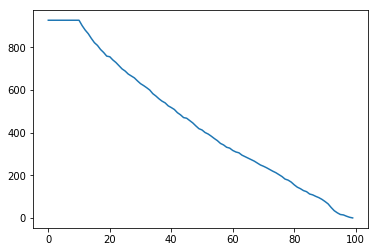

In [23]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.plot([len(selected[selected.score > i]) for i in np.arange(0, 100)]);

In [26]:
print('No. of kilns detected: ', len(selected[selected.score > 30]))

No. of kilns detected:  630


In [27]:
gis = GIS('https://deldev.maps.arcgis.com', 'demos_deldev', os.environ.get('DEMOSPWD'))

In [28]:
brick_kilns = gis.content.import_data(selected, title='ncr_brick_kilns', tags='deeplearning')    
brick_kilns

<Item title:"ncr_brick_kilns" type:Feature Layer Collection owner:demos_deldev>